In [10]:
import os
import numpy as np
import torch
import pandas as pd
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [11]:
os.path.join(os.getcwd(), "src/", "motor_cortex/data/")

'/home/linux-pc/gh/CRCNS/src/motor_cortex/data/'

In [13]:
data_file_dir = os.path.join(os.getcwd(), "src/", "motor_cortex/MATLAB/")
data_file_l = glob(os.path.join(data_file_dir, "**", "*.csv"), recursive=True)
data_file_l

['/home/linux-pc/gh/CRCNS/src/motor_cortex/MATLAB/motion_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/MATLAB/ecog_data.csv']

In [14]:
data_file_l

['/home/linux-pc/gh/CRCNS/src/motor_cortex/MATLAB/motion_data.csv',
 '/home/linux-pc/gh/CRCNS/src/motor_cortex/MATLAB/ecog_data.csv']

In [20]:
motion_data_file = data_file_l[0]

In [22]:
ecog_data_file = data_file_l[1]

In [17]:
motion_data

'/home/linux-pc/gh/CRCNS/src/motor_cortex/MATLAB/motion_data.csv'

In [18]:
ecog_data

'/home/linux-pc/gh/CRCNS/src/motor_cortex/MATLAB/ecog_data.csv'

In [28]:
motion_data_bilateral_2018_07_12_S1 = pd.read_csv(motion_data_file)

In [31]:
motion_data_bilateral_2018_07_12_S1["Motion_time"]

0           0.000
1           0.024
2           0.044
3           0.062
4           0.082
           ...   
51288    1026.151
51289    1026.170
51290    1026.191
51291    1026.211
51292    1026.241
Name: Motion_time, Length: 51293, dtype: float64

In [23]:
ecog_data_bilateral_2018_07_12_S1 = pd.read_csv(ecog_data_file)
channel_data = ecog_data_bilateral_2018_07_12_S1.columns[1:-1].values
ecog_data_bilateral_2018_07_12_S1[channel_data].values

array([[ 548.44,  445.42,  398.44, ...,  406.98,  382.4 ,  754.9 ],
       [ 469.38,  417.6 ,  299.79, ...,  245.42,  405.31,  654.38],
       [ 321.88,  202.92,  220.83, ...,   97.4 ,  346.46,  533.23],
       ...,
       [-298.85,  -66.67,  116.15, ..., -176.35,  -57.81,  -28.02],
       [-389.06,  -96.04,  127.29, ..., -180.  ,  -88.54,  -81.25],
       [-288.85,   32.4 ,  161.15, ..., -138.65, -104.17, -129.58]],
      shape=(1024398, 64))

In [26]:
ecog_data_bilateral_2018_07_12_S1["Time"]

0             0.000
1             0.001
2             0.002
3             0.003
4             0.004
             ...   
1024393    1024.393
1024394    1024.394
1024395    1024.395
1024396    1024.396
1024397    1024.397
Name: Time, Length: 1024398, dtype: float64

In [27]:
motion_data["Motion_time"]

0           0.000
1           0.024
2           0.044
3           0.062
4           0.082
           ...   
51288    1026.151
51289    1026.170
51290    1026.191
51291    1026.211
51292    1026.241
Name: Motion_time, Length: 51293, dtype: float64

In [25]:
1024398 / 51293

19.971497085372274

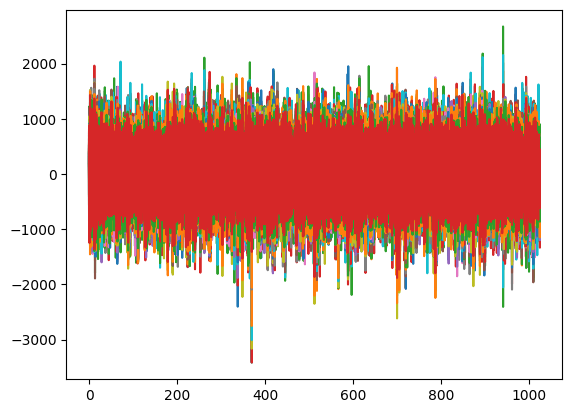

: 

In [ ]:
plt.plot(ecog_data_bilateral_2018_07_12_S1["Time"], ecog_data_bilateral_2018_07_12_S1[channel_data].values)

In [ ]:
ecog_data_bilateral_2018_07_12_S1

,Time,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,Channel 9,...,Channel 56,Channel 57,Channel 58,Channel 59,Channel 60,Channel 61,Channel 62,Channel 63,Channel 64,Fs
0,0.000,548.44,445.42,398.44,542.92,617.81,203.23,305.10,402.81,435.21,...,299.48,490.21,227.19,508.02,351.56,386.04,406.98,382.40,754.90,1000
1,0.001,469.38,417.60,299.79,514.38,521.77,65.21,268.33,342.29,270.10,...,267.92,418.85,121.98,396.88,279.48,385.10,245.42,405.31,654.38,1000
2,0.002,321.88,202.92,220.83,351.67,380.21,-47.29,200.31,210.00,196.46,...,121.04,438.75,90.94,329.17,215.42,372.29,97.40,346.46,533.23,1000
3,0.003,268.85,104.38,163.65,266.67,326.15,-66.15,162.40,137.50,157.40,...,125.94,435.42,128.96,296.67,193.75,367.19,110.21,287.71,489.38,1000
4,0.004,-23.23,-162.08,-154.17,47.29,32.60,-344.79,-54.38,-86.25,-155.83,...,-31.15,260.63,44.06,105.63,52.50,208.54,-99.90,166.98,253.33,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024393,1024.393,-411.77,-192.08,-22.71,-397.81,-262.81,-111.46,-334.38,-240.21,-277.40,...,18.85,5.21,58.54,-65.83,218.23,-74.38,-136.56,40.83,82.81,1000
1024394,1024.394,-400.73,-141.46,-9.06,-437.40,-281.46,-72.50,-300.94,-231.04,-276.67,...,-21.67,-49.69,-48.54,-89.17,88.02,-71.88,-221.15,-4.90,-10.31,1000
1024395,1024.395,-298.85,-66.67,116.15,-315.10,-204.58,25.73,-120.00,-108.75,-208.44,...,-37.50,11.04,-112.92,-15.10,66.35,-73.33,-176.35,-57.81,-28.02,1000
1024396,1024.396,-389.06,-96.04,127.29,-345.00,-279.90,-26.98,-152.40,-163.96,-245.52,...,-54.06,-20.31,-200.10,28.23,-30.42,-74.48,-180.00,-88.54,-81.25,1000


In [ ]:
ecog_data_bilateral_2018_07_12_S1 = pd.read_json(data_file_l[1])

In [29]:
motion_data_bilateral_2018_07_12_S1 = pd.read_csv(active_data)

KeyboardInterrupt: 

In [21]:
motion_data_bilateral_2018_07_12_S1

,Motion_time,Left_Wrist_X,Left_Wrist_Y,Left_Wrist_Z,Right_Wrist_X,Right_Wrist_Y,Right_Wrist_Z,Fsm
0,0.000,-0.589976,-0.590399,-0.228992,-2.308375,0.156087,1.136016,50
1,0.024,-0.587234,-0.570032,-0.211194,-2.320215,0.178141,1.007657,50
2,0.044,-0.577829,-0.577735,-0.216256,-2.214928,0.090902,0.881989,50
3,0.062,-0.525398,-0.500043,-0.190533,-2.149553,0.041767,0.758740,50
4,0.082,-0.567822,-0.568262,-0.240272,-2.122593,0.021872,0.642614,50
...,...,...,...,...,...,...,...,...
51288,1026.151,0.983919,1.375122,-0.250602,1.189555,0.672937,0.693372,50
51289,1026.170,0.996104,1.382786,-0.243810,1.192434,0.676611,0.612822,50
51290,1026.191,0.987838,1.387219,-0.243038,1.205653,0.697864,0.532673,50
51291,1026.211,0.978803,1.392886,-0.242469,1.207818,0.697904,0.456947,50


In [ ]:
ecog_data_bilateral_2018_07_12_S1 = pd.read_csv()